In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib widget
from ipywidgets import HBox, FloatSlider

In [2]:
df = pd.read_pickle('../bag_data/square_fixed.pickle')

In [3]:
df.shape

(63034, 55)

In [4]:
df_imu_linear = df[[ 'imu__linear_acceleration_y', 'imu__linear_acceleration_z']].dropna()
df_imu_linear['imu__linear_acceleration_y'] -= -1.568076
df_imu_linear['imu__linear_acceleration_z'] -= -0.005081
linear_g = np.sum(np.abs(df_imu_linear.values),axis=1)
linear_g.shape

(17977,)

In [5]:
df_imu_linear.describe()

,imu__linear_acceleration_y,imu__linear_acceleration_z
count,17977.000000,17977.000000
mean,0.006365,-0.002251
std,0.072198,0.123268
min,-0.742705,-2.709622
25%,-0.027044,-0.030365
50%,0.010134,-0.000705
75%,0.038016,0.028955
max,0.902387,1.996380


In [6]:
df_g = pd.Series(linear_g)
df_g.describe()


count    17977.000000
mean         0.104242
std          0.137200
min          0.001544
25%          0.047198
50%          0.076956
75%          0.122835
max          3.327947
dtype: float64

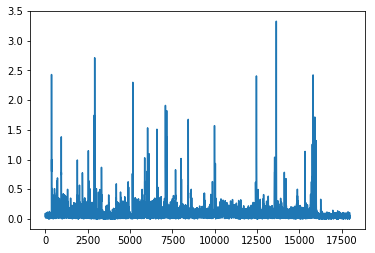

In [7]:
plt.plot(linear_g)
plt.show()

In [8]:
imu_ang_vel_x = df.imu__angular_velocity_x.values
imu_linear_vel_y = df.imu__linear_acceleration_y.values
imu_linear_vel_z = df.imu__linear_acceleration_z.values


In [9]:
def calc(gain_angular):
    ground_last_theta = 0
    last_imu_linear_acc_y = 0
    last_imu_linear_acc_z = 0
    g_th_max = 10.0
    g_th_min =  0.143793
    imu_angular_bias = -0.345464
    imu_linear_acc_y_bias = -1.568076
    imu_linear_acc_z_bias = -0.005081
    fake_ground_pose_theta = 0.495
    
    a = np.zeros((df[df.imu__angular_velocity_x.notnull()].shape[0],1))
    rangea = int(df[df.imu__angular_velocity_x.notnull()].shape[0]/4.0)
    a[:rangea] = 0
    a[rangea:rangea*2] = math.pi/2.0
    a[rangea*2:rangea*3] = math.pi
    a[rangea*3:-1] = 1.5 * math.pi
    ground_thetas = a

    #gain_angular = 0.99987
    dt = 0.01
    calculated_thetas = []
    for i in range(df.shape[0]):
        if not np.isnan(imu_linear_vel_y[i]):
            last_imu_linear_acc_y = imu_linear_vel_y[i]
        if not np.isnan(imu_linear_vel_z[i]):
            last_imu_linear_acc_z = imu_linear_vel_z[i]
        if not np.isnan(imu_ang_vel_x[i]):
            new_theta = (imu_ang_vel_x[i] - imu_angular_bias)* dt
            current_g = np.abs(last_imu_linear_acc_y - imu_linear_acc_y_bias) + np.abs(last_imu_linear_acc_z- imu_linear_acc_z_bias)
            #print(current_g)
            if current_g >= g_th_min and current_g <= g_th_max:
                theta_acc = np.arctan2(last_imu_linear_acc_y,last_imu_linear_acc_z) 
                new_theta = gain_angular * new_theta + (1.0-gain_angular) * theta_acc
                #print( theta_acc)
            calculated_thetas.append(-new_theta)
    calculated_thetas_cumsum = np.cumsum(calculated_thetas)
    return np.unwrap(ground_thetas),calculated_thetas_cumsum

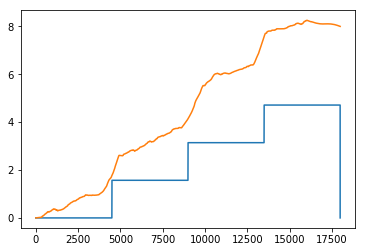

In [27]:
fig = plt.figure()
ground,computed = calc(0.9990) #99989 #99976555
plt.plot(ground)
plt.plot(computed)
plt.show()

    

In [38]:
from scipy.spatial import distance

vel_linear_x = df.vel__twist_linear_x.values
ground_pose_x = df.robot_markerset_ground_pose__x.values
ground_pose_y = df.robot_markerset_ground_pose__y.values
prev_x = 0
prev_y = 0
dt = 1
p2p_ground_euc_distances = []
linear_euc_distances = []
dt = 0
for i in range(df.shape[0]):
    if not np.isnan(vel_linear_x[i]):
        linear_euc_distances.append(abs(vel_linear_x[i]) * dt)
    if not np.isnan(ground_pose_x[i]) and not np.isnan(ground_pose_y[i]):
        p2p_ground_euc_distances.append(distance.euclidean((ground_pose_x[i],ground_pose_y[i]), (prev_x,prev_y)))
        prev_x = ground_pose_x[i]
        prev_y = ground_pose_y[i]



AttributeError: 'DataFrame' object has no attribute 'robot_markerset_ground_pose__x'

In [ ]:
p2p_ground_euc_distances[:10]

In [ ]:
linear_acc_euc_distances[10000:10010]

In [ ]:
fig = plt.figure()
plt.plot(np.cumsum(p2p_ground_euc_distances))
plt.plot(np.cumsum(linear_acc_euc_distances))
plt.show()